In [21]:
import sys, os
import csv
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [22]:
def user_import(filepath):
    """
    Given a filepath to a dataset, return a list of dataframes
    per user.
    """
    # open the file
    with open(filepath, 'r') as inputfile:
        # import csv with pandas
        file_df = pd.read_csv(inputfile, header = 0)
        
        file_df['created_at'] = pd.to_datetime(file_df['created_at'], format="%Y-%m-%d %H:%M:%S", utc=True)
        file_df['created_at'] = file_df['created_at'].dt.tz_convert(pytz.timezone('US/Eastern'))
        # determine list of unique users
        userlist = file_df['user_id'].tolist()
        userset = set(userlist)
        
        user_list = []
        # iterate through each user and save out data
        for user in userset:
            user_df = file_df.loc[file_df['user_id'] == user]
            #user_df['user_id'] = user
            user_df.reset_index(drop=True, inplace=True)
            user_list.append(user_df)

    return file_df, user_list

In [23]:
file_dataset, user_dataset = user_import('C:/Users/xweng/Desktop/heatseek_geocoded.csv')
print(file_dataset)

        Unnamed: 0  user_id                        address  zip_code  \
0                0    381.0                 124 E 176th St   10453.0   
1                1    390.0             1802 Ocean Parkway   11223.0   
2                2    492.0                  341 E 19th St   11226.0   
3                3    389.0                   4836 41st St   11104.0   
4                4    167.0                   150 Court St   11201.0   
5                5    163.0                    88 Starr St   11237.0   
6                6    396.0                 158 Norman Ave   11222.0   
7                7    446.0                  944 Marcy Ave   11216.0   
8                8    401.0               10 Ocean Parkway   11218.0   
9                9    387.0                 138 W 133rd St   10030.0   
10              10    489.0             261 Clinton Street   11201.0   
11              11    420.0         2061 Bay Ridge Parkway   11204.0   
12              12    443.0               607 Flatbush Ave   112

In [24]:
def outdoor_uptime(file_dataset):
    """
    Calculate the percentage of all measurements that have outdoor temperature.
    :param file_dataset: first dataset returned by user_import()
    :type file_dataset: DataFrame
    """
    
    # count the number of rows that don't have NaN values in the outdoor_temp column.
    outdoor_dataset = file_dataset.loc[file_dataset['outdoor_temp'].notna()]
    return len(outdoor_dataset) / len(file_dataset)

In [25]:
od_up = outdoor_uptime(file_dataset)
print('The outdoor_temp uptime is ', od_up )

The outdoor_temp uptime is  0.9925699753071816


In [26]:
def split_daynight(file_dataset):
    """
    Split overall dataset into day and night
    :param file_dataset: first dataset returned by user_import()
    :type file_dataset: DataFrame
    """
    # day and night time definitions
    day = [hr for hr in range(6, 22)]
    night = [22, 23, 0, 1, 2, 3, 4, 5]
    # pull out the rows that have 'created_at' column values with hour values in either range
    # .dt interprets the Series as datetime
    # .hour gets the hour value
    # .isin checks if the value is in a list
    day_dataset = file_dataset.loc[file_dataset['created_at'].dt.hour.isin(day)]
    night_dataset = file_dataset.loc[file_dataset['created_at'].dt.hour.isin(night)]
    
    return day_dataset, night_dataset

In [27]:
def day_scatter(file_dataset):
    """
    Plot a scatterplot of the daytime dataset
    :param file_dataset: first dataset returned by split_daynight()
    :type file_dataset: DataFrame
    """
    # Split the dataset into violation and non-violation
    vio_true = file_dataset.loc[file_dataset['violation'] == True]
    vio_false = file_dataset.loc[file_dataset['violation'] == False]
    
    # For both datasets, get the Series for indoor/outdoor temperatures, 
    # as well as the timestamp for heatmapping
    vt_yval = vio_true['temp']
    vt_xval = vio_true['outdoor_temp']
    vt_c = mdates.date2num(vio_true['created_at'])
    
    vf_yval = vio_false['temp']
    vf_xval = vio_false['outdoor_temp']
    vf_c = mdates.date2num(vio_false['created_at'])
    
    # Getting the min and max timestamps for accurate heatmapping
    cb_min = min((min(vf_c), min(vt_c)))
    cb_max = max((max(vf_c), max(vt_c)))
    
    # Defining the datapoints to plot the temp violation cutoffs
    base = range(0, 100)
    day_room = [68] * 100
    day_out = [55] * 100
    
    # matplotlib magic
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    ax1.scatter(vf_xval, vf_yval, c='g', marker='.', label='nominal')
    ax1.scatter(vt_xval, vt_yval, c='r', marker='.', label='violation')
    ax1.plot(base, base, 'b-')
    ax1.plot(base, day_room, 'k-')
    ax1.plot(day_out, base, 'k-')
    ax1.legend()
    
    ax1.set_xlabel('outdoor temp. (F)')
    ax1.set_ylabel('indoor temp. (F)')
    fig.suptitle('2018-2019 Heat Season Tenant Daytime Indoor vs Outdoor Temp', fontsize='x-large')
    
    sc = ax2.scatter(vf_xval, vf_yval, c=vf_c, marker='.', cmap='winter', vmin=cb_min, vmax=cb_max)
    ax2.scatter(vt_xval, vt_yval, c=vt_c, marker='.', cmap='winter', vmin=cb_min, vmax=cb_max)
    ax2.plot(base, base, 'b-')
    ax2.plot(base, day_room, 'k-')
    ax2.plot(day_out, base, 'k-')
    
    ax2.set_xlabel('outdoor temp. (F)')
    ax2.set_ylabel('indoor temp. (F)')
    #ax2.set_title('2017-2018 Heat Season Tenant Indoor vs Outdoor Temp')
    
    cbar = fig.colorbar(sc, ax = np.array([ax1,ax2]).ravel().tolist(), ticks=[cb_min, cb_max])
    cbar.ax.set_yticklabels([mdates.num2date(cb_min, pytz.timezone('US/Eastern')).strftime("%Y-%m-%d"), \
                            mdates.num2date(cb_max, pytz.timezone('US/Eastern')).strftime("%Y-%m-%d")])

In [28]:
def night_scatter(file_dataset):
    """
    Plot a scatterplot of the nighttime dataset
    :param file_dataset: second dataset returned by split_daynight()
    :type file_dataset: DataFrame
    """
    # Split the dataset into violation and non-violation
    vio_true = file_dataset.loc[file_dataset['violation'] == True]
    vio_false = file_dataset.loc[file_dataset['violation'] == False]
    
    # For both datasets, get the Series for indoor/outdoor temperatures, 
    # as well as the timestamp for heatmapping
    vt_yval = vio_true['temp']
    vt_xval = vio_true['outdoor_temp']
    vt_c = mdates.date2num(vio_true['created_at'])
    
    vf_yval = vio_false['temp']
    vf_xval = vio_false['outdoor_temp']
    vf_c = mdates.date2num(vio_false['created_at'])
    
    # Getting the min and max timestamps for accurate heatmapping
    cb_min = min((min(vf_c), min(vt_c)))
    cb_max = max((max(vf_c), max(vt_c)))

    # Defining the datapoints to plot the temp violation cutoffs
    base = range(0, 100)
    night_room = [62] * 100
    
    # matplotlib magic
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    ax1.scatter(vf_xval, vf_yval, c='g', marker='.', label='nominal')
    ax1.scatter(vt_xval, vt_yval, c='r', marker='.', label='violation')
    ax1.plot(base, base, 'b-')
    ax1.plot(base, night_room, 'k-')
    ax1.legend()
    
    ax1.set_xlabel('outdoor temp. (F)')
    ax1.set_ylabel('indoor temp. (F)')
    fig.suptitle('2018-2019 Heat Season Tenant Nighttime Indoor vs Outdoor Temp', fontsize='x-large')
    
    sc = ax2.scatter(vf_xval, vf_yval, c=vf_c, marker='.', cmap='winter', vmin=cb_min, vmax=cb_max)
    ax2.scatter(vt_xval, vt_yval, c=vt_c, marker='.', cmap='winter', vmin=cb_min, vmax=cb_max)
    ax2.plot(base, base, 'b-')
    ax2.plot(base, night_room, 'k-')
    
    ax2.set_xlabel('outdoor temp. (F)')
    ax2.set_ylabel('indoor temp. (F)')
    #ax2.set_title('2017-2018 Heat Season Tenant Indoor vs Outdoor Temp')
    
    cbar = fig.colorbar(sc, ax = np.array([ax1,ax2]).ravel().tolist(), ticks=[cb_min, cb_max])
    cbar.ax.set_yticklabels([mdates.num2date(cb_min, pytz.timezone('US/Eastern')).strftime("%Y-%m-%d"), \
                            mdates.num2date(cb_max, pytz.timezone('US/Eastern')).strftime("%Y-%m-%d")])
    

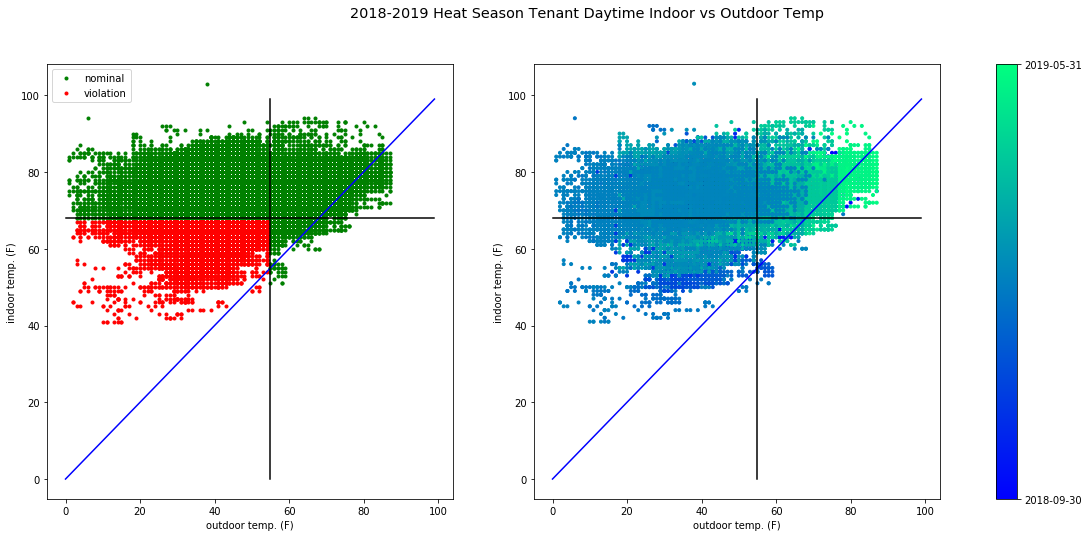

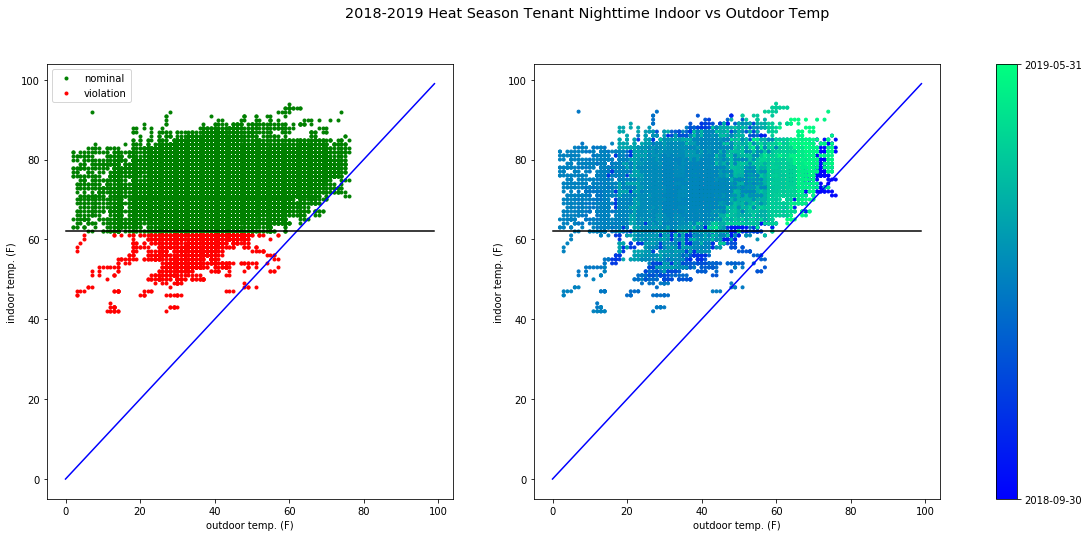

In [29]:
day, night = split_daynight(file_dataset)
day_scatter(day)
night_scatter(night)